In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold,  KFold
from lib.full_flow_dataloader import load_full_flow_data
import matplotlib.pyplot as plt
# Use for report, but can't copy-paste, so disabling
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns


In [5]:
# def custom_kfold_cross_validation_extreme(data, n_splits: int, target: str, group_by: str, extreme_percentage: float, random_state=None):

train_processed, test_processed = load_full_flow_data()
data = pd.concat([train_processed, test_processed])
target = 'MgO'
group_by = 'Sample Name'
extreme_percentage = 0.05
n_splits = 5
random_state = 42

In [6]:
from lib.cross_validation import custom_kfold_cross_validation_new

# folds_custom = stratified_group_kfold_split(
#     data, group_by=group_by, target=target, num_bins=5, n_splits=5, random_state=42
# )

folds_custom, train_full, test_full = custom_kfold_cross_validation_new(
    data=data, k=5, group_by=group_by, target=target, random_state=42
)



<Figure size 1200x600 with 0 Axes>

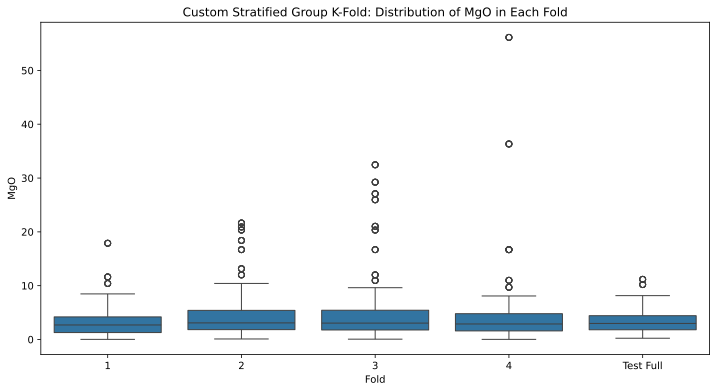

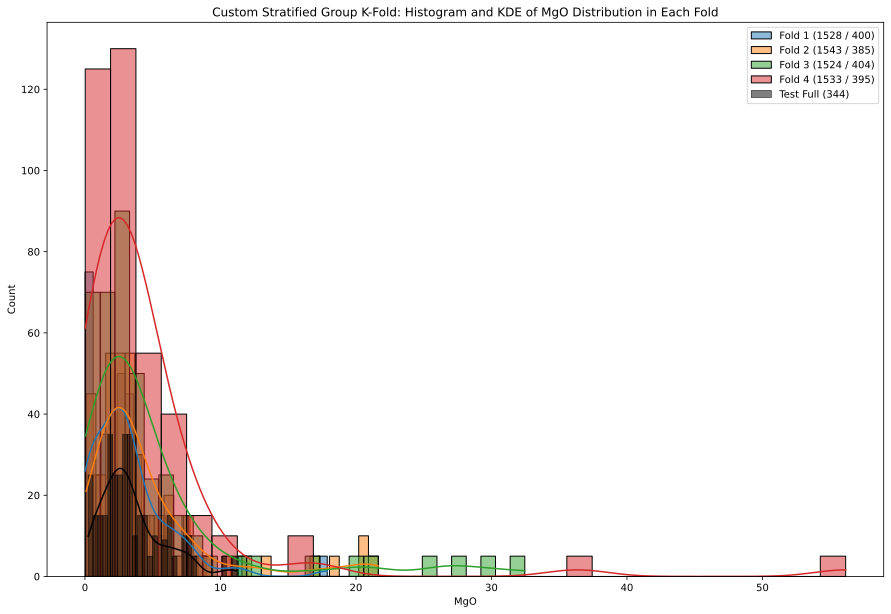

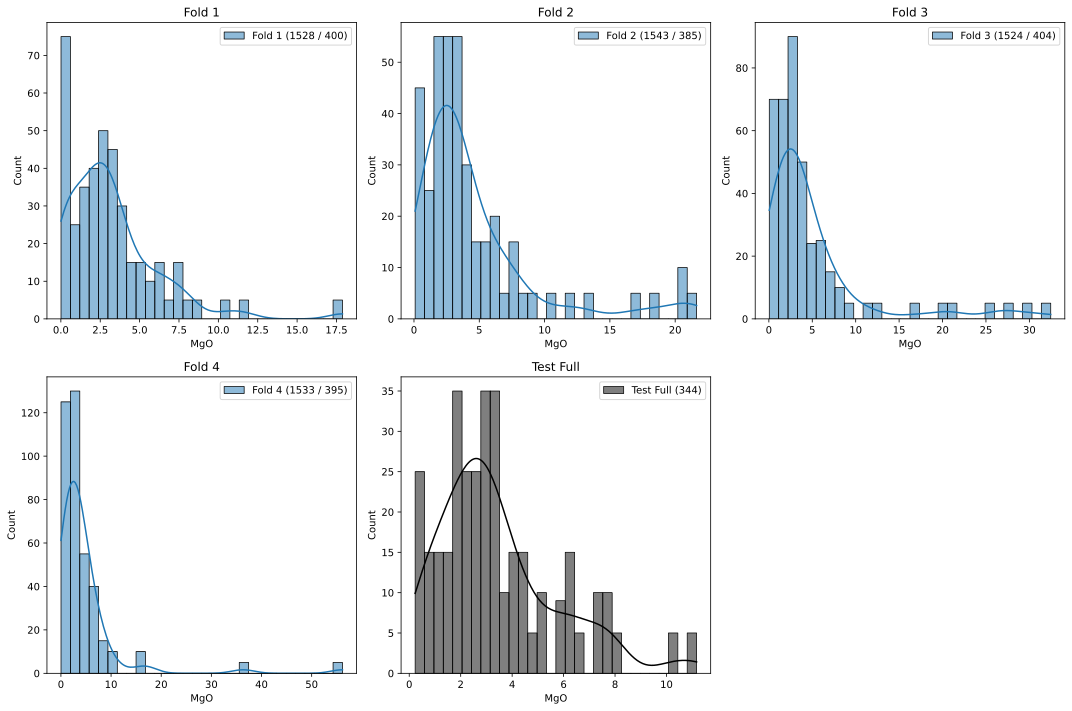

In [7]:

# == DISTRIBUTION PLOT ==
# Prepare data for plotting
fold_data_custom = []

for i, (_, test) in enumerate(folds_custom):
    fold_target = test[target]
    for value in fold_target:
        fold_data_custom.append((i+1, value))

# Add test_full data
test_full_target = test_full[target]
for value in test_full_target:
    fold_data_custom.append(('Test Full', value))

fold_df_custom = pd.DataFrame(fold_data_custom, columns=['Fold', target])

# Plot the distribution of SiO2 in each fold
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fold', y=target, data=fold_df_custom)
plt.title(f'Custom Stratified Group K-Fold: Distribution of {target} in Each Fold')
plt.xlabel('Fold')
plt.ylabel(target)
plt.show()

# == HISTOGRAM PLOT ==
# Plot the histogram and KDE for each fold
plt.figure(figsize=(15, 10))

for i, (train_full, test) in enumerate(folds_custom):
    fold_target = test[target]
    sns.histplot(fold_target, kde=True, bins=30, label=f'Fold {i+1} ({len(train_full)} / {len(test)})', alpha=0.5)

# Add test_full data
sns.histplot(test_full_target, kde=True, bins=30, label=f'Test Full ({len(test_full)})', alpha=0.5, color='black')

plt.title(f'Custom Stratified Group K-Fold: Histogram and KDE of {target} Distribution in Each Fold')
plt.xlabel(target)
plt.ylabel('Count')
plt.legend()
plt.show()

# == HISTOGRAM PLOT ==
# Plot the histograms for each fold in a grid layout
num_folds = len(folds_custom)
num_cols = 3
num_rows = (num_folds + num_cols - 1) // num_cols

plt.figure(figsize=(15, 5 * num_rows))

for i, (train_full, test) in enumerate(folds_custom):
    fold_target = test[target]
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(fold_target, kde=True, bins=30, label=f'Fold {i+1} ({len(train_full)} / {len(test)})', alpha=0.5)
    plt.title(f'Fold {i+1}')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend()

# Add test_full data in a separate subplot
plt.subplot(num_rows, num_cols, num_folds + 1)
sns.histplot(test_full_target, kde=True, bins=30, label=f'Test Full ({len(test_full)})', alpha=0.5, color='black')
plt.title('Test Full')
plt.xlabel(target)
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import GroupKFold
import numpy as np

# Extract necessary columns
X = data.drop(columns=[target, group_by, 'ID'])
y = data[target]
groups = data[group_by]



# Initialize GroupKFold with 5 splits
gkf = GroupKFold(n_splits=5)

# Generate the stratified folds
folds = list(gkf.split(X, y, groups))

# Function to check the distribution of the target variable in each fold
def check_fold_distribution(folds, y):
    for i, (train_index, test_index) in enumerate(folds):
        fold_target = y.iloc[test_index]
        print(f"Fold {i+1} - Mean: {fold_target.mean()}, Std: {fold_target.std()}, Min: {fold_target.min()}, Max: {fold_target.max()}")

# Check the distribution of SiO2 in each fold
check_fold_distribution(folds, y)

Fold 1 - Mean: 4.0801579866493505, Std: 4.570323123024549, Min: 0.06, Max: 29.23
Fold 2 - Mean: 4.41427617887013, Std: 7.588601121254389, Min: 0.02, Max: 56.14
Fold 3 - Mean: 5.359530468844156, Std: 6.753323026163802, Min: 0.01, Max: 32.46
Fold 4 - Mean: 3.779365573246753, Std: 3.522038451587322, Min: 0.16, Max: 18.4
Fold 5 - Mean: 3.5186858068814435, Std: 2.571836280749639, Min: 0.19, Max: 16.69


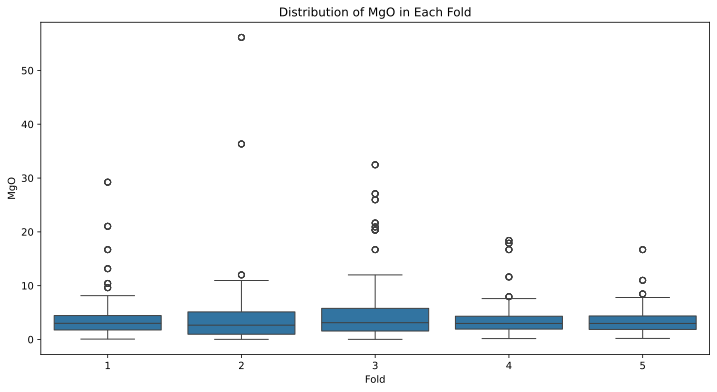

In [9]:
# Prepare data for plotting
fold_data = []

for i, (train_full, test_full) in enumerate(folds):
    fold_target = y.iloc[test_full]
    for value in fold_target:
        fold_data.append((i+1, value))

fold_df = pd.DataFrame(fold_data, columns=['Fold', target])

# Plot the distribution of SiO2 in each fold
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fold', y=target, data=fold_df)
plt.title(f'Distribution of {target} in Each Fold')
plt.xlabel('Fold')
plt.ylabel(target)
plt.show()


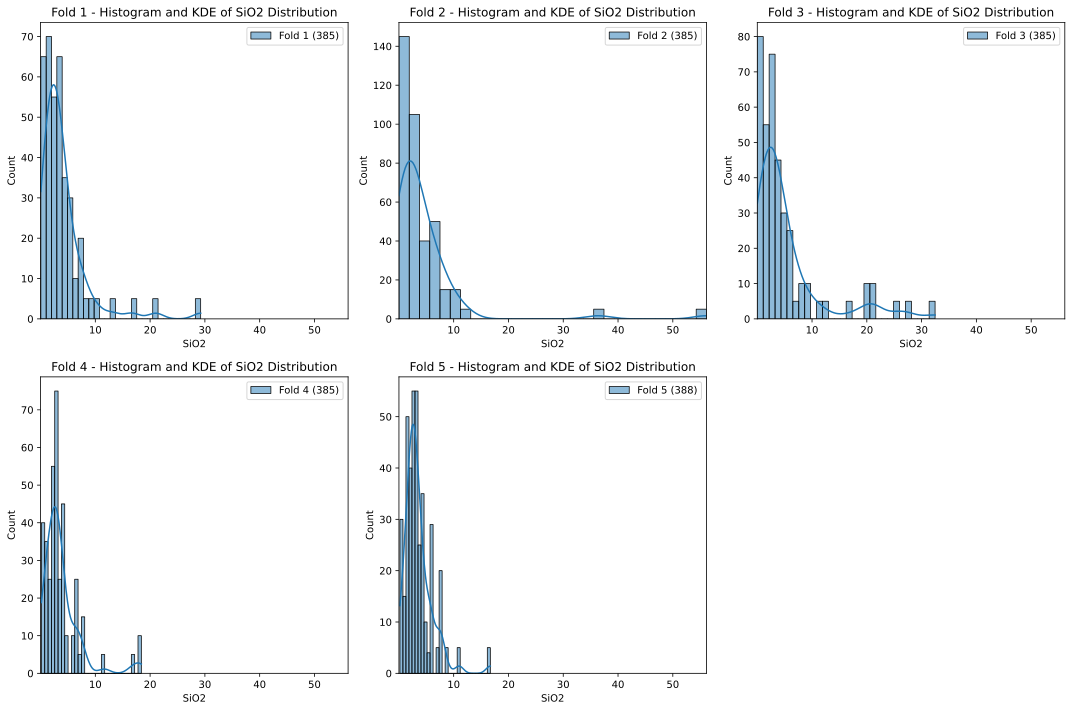

In [10]:
# Plot the histogram and KDE for each fold as separate plots in a grid with 2 rows
n_folds = len(folds)
n_cols = (n_folds + 1) // 2  # Calculate the number of columns needed

fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(15, 10))

# Determine the global min and max for x and y values
all_fold_targets = pd.concat([y.iloc[test_index] for _, test_index in folds])
x_min, x_max = all_fold_targets.min(), all_fold_targets.max()
# y_min, y_max = 0, max([sns.histplot(y.iloc[test_index], kde=True, bins=30).get_lines()[0].get_data()[1].max() for _, test_index in folds])

for i, (train_full, test_full) in enumerate(folds):
    row = i // n_cols
    col = i % n_cols
    fold_target = y.iloc[test_full]
    sns.histplot(fold_target, kde=True, bins=30, ax=axes[row, col], label=f'Fold {i+1} ({len(fold_target)})', alpha=0.5)
    axes[row, col].set_title(f'Fold {i+1} - Histogram and KDE of SiO2 Distribution')
    axes[row, col].set_xlabel('SiO2')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xlim(x_min, x_max)
    # axes[row, col].set_ylim(y_min, y_max)
    axes[row, col].legend()

# Remove any empty subplots
if n_folds % 2 != 0:
    fig.delaxes(axes[1, n_cols - 1])

plt.tight_layout()
plt.show()


In [11]:
tar_and_group_df = pd.concat([data[target], data[group_by]], axis=1)
tar_and_group_df

,MgO,Sample Name
0,3.85,jsc1421
1,3.85,jsc1421
2,3.85,jsc1421
3,3.85,jsc1421
4,3.85,jsc1421
...,...,...
385,6.46,mo7
386,6.46,mo7
387,6.46,mo7
388,6.46,mo7


In [12]:
tar_and_group_df = tar_and_group_df.drop_duplicates().reset_index(drop=True)
tar_and_group_df



,MgO,Sample Name
0,3.85,jsc1421
1,0.70,pg7
2,1.75,r61
3,1.18,201424
4,1.91,gl2mt
...,...,...
381,7.79,sanci
382,16.69,jsc1367
383,2.02,r2100m
384,0.76,nau1


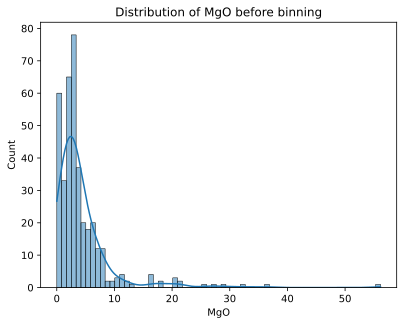

In [13]:
sns.histplot(data=tar_and_group_df, x=target, kde=True)
plt.title(f"Distribution of {target} before binning")
plt.show()

In [14]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

def assign_bins(data, target, n_bins, strategy='quantile'):
    """
    Assigns data into bins using KBinsDiscretizer and sets the bins as discrete values.

    Parameters:
    data (pd.DataFrame): The input data.
    target (str): The target column to be binned.
    n_bins (int): The number of bins to create.
    strategy (str): The strategy used to define the widths of the bins. Default is 'quantile'.

    Returns:
    pd.DataFrame: DataFrame with an additional column 'bins' containing the bin assignments.
    """
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    data['bins'] = discretizer.fit_transform(data[[target]]).astype(int)
    return data

# Example usage:
# data = pd.DataFrame({'SiO2': [56.13, 57.60, 64.80, 77.94, 70.73, 44.13, 54.58, 67.82, 40.28, 40.79]})
# binned_data = assign_bins(data, target='SiO2', n_bins=5)
# print(binned_data)

In [15]:
out = assign_bins(data=tar_and_group_df.copy(), target=target, n_bins=n_splits, strategy='quantile')



In [16]:
out['bins'].unique()

array([3, 0, 1, 2, 4])

In [17]:
out

,MgO,Sample Name,bins
0,3.85,jsc1421,3
1,0.70,pg7,0
2,1.75,r61,1
3,1.18,201424,0
4,1.91,gl2mt,1
...,...,...,...
381,7.79,sanci,4
382,16.69,jsc1367,4
383,2.02,r2100m,1
384,0.76,nau1,0


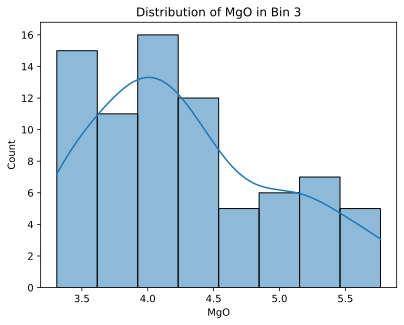

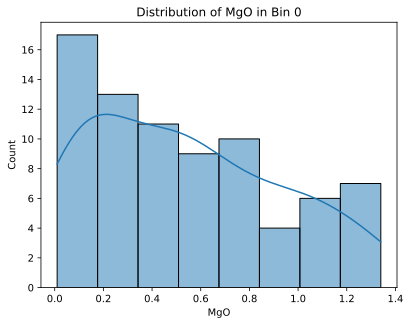

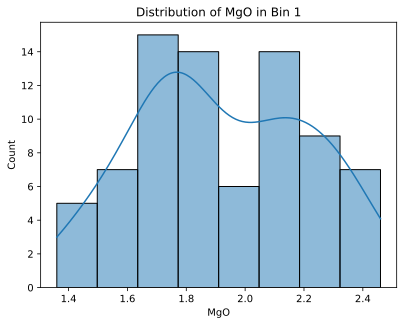

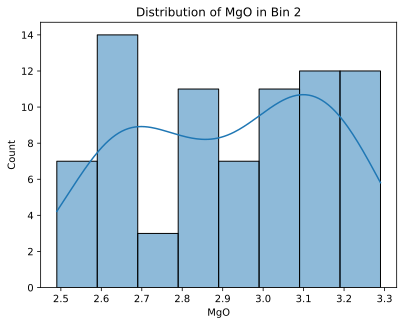

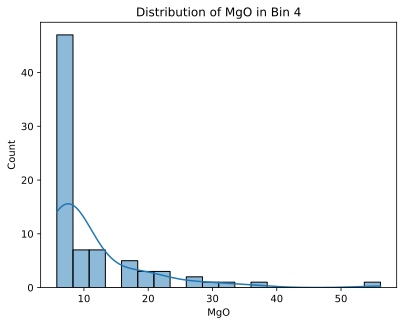

In [18]:
for bin_value in out['bins'].unique():
    sns.histplot(data=out[out['bins'] == bin_value], x=target, kde=True)
    plt.title(f"Distribution of {target} in Bin {bin_value}")
    plt.show()

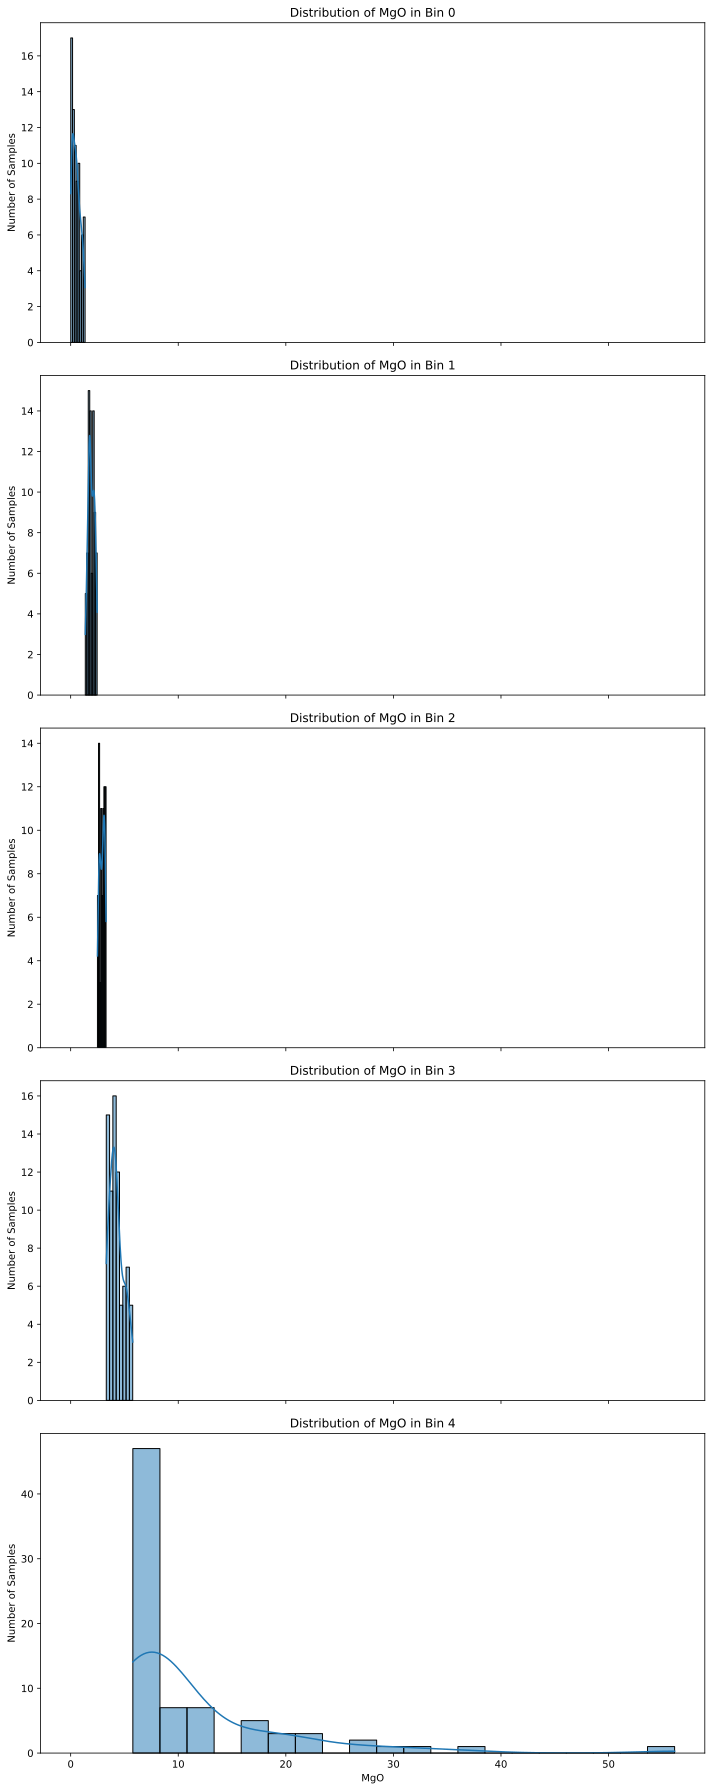

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

num_bins = len(out['bins'].unique())

fig, axes = plt.subplots(num_bins, 1, figsize=(10, 5 * num_bins), sharex=True)
x = out['bins'].unique()
x.sort()

for i, bin_value in enumerate(x):
    ax = axes[i]
    sns.histplot(x=target, data=out[out['bins'] == bin_value], kde=True, ax=ax)
    ax.set_title(f"Distribution of {target} in Bin {bin_value}")
    ax.set_xlabel(target)
    ax.set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()

In [20]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# # Initialize the StratifiedKFold object
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# # Create a new column 'fold' in tar_and_group_df to store the fold assignment
# tar_and_group_df['fold'] = -1

# # Assign each sample to a fold
# for fold_number, (train_index, test_index) in enumerate(skf.split(tar_and_group_df, target_discretized)):
#     tar_and_group_df.loc[tar_and_group_df.index[test_index], 'fold'] = fold_number

# tar_and_group_df['fold'].value_counts()




In [21]:
# # Create bins by unique items as determined by the group_by specification
# unique_groups = data[group_by].unique()
# folds_df = pd.qcut(range(len(unique_groups)), q=n_splits, labels=False)
# folds_df = pd.DataFrame({group_by: unique_groups, 'fold': folds_df})
# folds_df = pd.merge(data, folds_df, on=group_by, how='left')

# folds_df

In [22]:
# Assert that all samples with the same name also have the same value in 'fold'
# assert all(folds_df.groupby(group_by)['fold'].nunique() == 1), "Samples with the same name have different fold values"


In [23]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# unique_folds = folds_df['fold'].unique()
# num_bins = len(unique_folds)

# fig, axes = plt.subplots(num_bins, 1, figsize=(20, 5 * num_bins), sharex=True)

# for i, bin_value in enumerate(unique_folds):
#     ax = axes[i]
#     sns.histplot(x=target, data=folds_df[folds_df['fold'] == bin_value], kde=True, ax=ax)
#     ax.set_title(f"Distribution of {target} in Fold {bin_value}")
#     ax.set_xlabel(target)
#     ax.set_ylabel("Number of Samples")

# plt.tight_layout()
# plt.show()

In [24]:
import numpy as np

"""
- Target rows, group_by column, extreme_percentage, n_splits, random_state
- Create bins by unique items as determined by the group_by specification
- Assert that all samples with the same name also have the same value in 'fold'
- Create a list of tuples, where each tuple contains the train and test sets for a fold
- Return the list of tuples
"""

# not: [1,2,3,4,5]
# yield (4/5, 1/5) five times
# 1 2 3 4 5
# ^________
# 1 2 3 4 5
# __^______


# def foo():
#     extreme_indices = folds_df[(folds_df[target] > folds_df[target].quantile(1 - extreme_percentage)) | (folds_df[target] < folds_df[target].quantile(extreme_percentage))].index
#     non_extreme_df = folds_df.drop(extreme_indices)
#     kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     for i, (train_index, test_index) in enumerate(kf.split(non_extreme_df, non_extreme_df['fold'], groups=folds_df['Sample Name'])):
#         extreme_part = np.array_split(extreme_indices, n_splits)
#         train_index = np.concatenate([non_extreme_df.index[train_index], extreme_part[i]])

#         train, test = folds_df.loc[train_index], folds_df.loc[non_extreme_df.index[test_index]]
#         yield train, test

# train_test_splits = list(foo())
# len(train_test_splits)


"\n- Target rows, group_by column, extreme_percentage, n_splits, random_state\n- Create bins by unique items as determined by the group_by specification\n- Assert that all samples with the same name also have the same value in 'fold'\n- Create a list of tuples, where each tuple contains the train and test sets for a fold\n- Return the list of tuples\n"

In [25]:
# train, test = train_test_splits[0]
# print(train.shape, test.shape)

# train["Sample Name"].value_counts()
# test["Sample Name"].value_counts()

# # Check for intersection between Sample Name columns in train and test sets
# train_sample_names = set(train["Sample Name"])
# test_sample_names = set(test["Sample Name"])

# intersection = train_sample_names.intersection(test_sample_names)

# if intersection:
#     print(f"Intersection found: {intersection}")
# else:
#     print("No intersection found between Sample Name columns in train and test sets.")
